##### INF8460 – Traitement automatique de la langue naturelle - Automne 2024

## TP2: Plongements de mots

## Identification de l'équipe:

### Groupe de laboratoire:

### Equipe numéro :

### Membres:

- Gervais Presley Koyaweda 2305686 (1/3)
- Lucie Legarez 2413157 (1/3)
- Ibrahima Ba 1943223 (1/3)

##### Le TP s'est fait de façon indépendante avec comme objectif de comparer nos différents résultats et de choisir les scipts les  plus simples et rapide à chaque étape. Tous les membres de l'équipe ont travaillé sur chacune des 3 parties et les efforts fournis ont été équitables.

* nature de la contribution: Décrivez brièvement ce qui a été fait par chaque membre de l’équipe. Tous les membres sont censés contribuer au développement. Bien que chaque membre puisse effectuer différentes tâches, vous devez vous efforcer d’obtenir une répartition égale du travail. Soyez précis ! N'indiquez pas seulement : travail réparti équitablement

### Objectif du TP

L'objectif de ce TP est d'entraîner un modèle de plongements lexicaux qui intègre des notions de synonymie et d'antonymie en utilisant des réseaux de neurones.

Contrairement aux plongements vus en cours comme GloVe ou Word2Vec, qui positionnent souvent les mots à proximité équivalente de leurs synonymes et antonymes, nous chercherons à faire distinguer à nos modèles les synonymes et antonymes, en rapprochant les mots de leurs synonymes et en les éloignant de leurs antonymes.

### Jeux de données

**Paires de synonymes et antonymes** (entraînement) : Les fichiers `train_synonyms.txt` et `train_antonymms.txt` contiennent les paires de synonymes et d'antonymes qui serviront à l'entraînement de nos modèles.
- train_synonyms: ~640k paires de synonymes
- train_antonyms: ~12k paires d'antonymes

**SimLex-999** (test) : Le fichier `simlex_english.txt` contient 1000 paires de mots et leur similarité entre 0 et 10. Des antonymes auront une similarité de 0 et des mots proches auront une similarité plus élevée. Par exemples :

- *nice* & *cruel* -> 0
- *violent* & *angry* -> 5.9
- *essential* & *necessary* -> 9.8

### Développement du TP

Le TP suivra les étapes suivantes:

- Partie 1 : Familiarisation avec GloVe, modèle de plongements de mots pré-entraîné
- Partie 2 : Évaluation de GloVe sur SimLex-999
- Partie 3 : Mise en place de la méthode d'entraînement
- Partie 4 : Entraînement de zéro (baseline)
- Partie 5 : Entraînement utilisant GloVe pré-entraîné et conclusion

Le TP est noté sur 89 points.

### Librairies autorisées

+ numpy
+ pandas
+ torch
+ matplotlib

Si vous voulez utiliser une autre librairie, veuillez demander à votre chargé de lab.

### Imports

Les imports effectués dans la cellule suivante devraient être suffisants pour faire tout ce TP.

In [ ]:
#pip install torch

In [1]:
from tqdm import tqdm
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

### 1. GloVe (10 Points)

Dans ce TP, nous allons utiliser le modèle pré-entraîné GloVe qui crée des plongements lexicaux de mots.

#### 1.1 Chargement du modèle

La cellule suivante permet charger le modèle GloVe pré-entraîné. Le chargement du modèle peut prendre quelques minutes.

In [2]:
#Décommenter pour télécharger les GloVe embeddings à partir de https://nlp.stanford.edu/projects/glove/
#!wget http://nlp.stanford.edu/data/glove.42B.300d.zip -P /content
#!unzip /content/glove.42B.300d.zip -d /content

--2024-10-07 01:57:38--  http://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.42B.300d.zip [following]
--2024-10-07 01:57:38--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2024-10-07 01:57:38--  https://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]


In [3]:
pretrained_model_path = 'glove.42B.300d.txt'

data_root = 'data'

train_synonyms_path = f"{data_root}/train_synonyms.txt"
train_antonyms_path = f"{data_root}/train_antonyms.txt"

eval_simlex = f'{data_root}/simlex_english.txt'

In [4]:
def load_word_vectors(filepath, vocab=None):
    """
    Télécharge le modèle pré-entraîné de plongements de mots en pytorch
    """
    word_to_index = {}
    embeddings = []
    index = 0

    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            if vocab is None or word in vocab:
                embedding = np.array(split_line[1:], dtype=np.float32)
                word_to_index[word] = index
                embeddings.append(embedding)
                index += 1

    embeddings = np.stack(embeddings)
    embeddings = torch.from_numpy(embeddings)
    return word_to_index, embeddings

In [5]:
word_to_index, embeddings = load_word_vectors(pretrained_model_path)

#### 1.2 Implémentez la fonction `cosine_similarity` avec pytorch et sans utiliser `torch.nn.CosineSimilarity` (2 points)

In [6]:
def cosine_similarity(a, b):
    """
    Calcule la matrice de similarité cosinus entre deux matrices

    Args :
        a   : torch.Tensor, shape=(n, d)
        b   : torch.Tensor, shape=(m, d)

    Returns:
    torch.Tensor, shape=(n, m)
    """
    # TODO

   # Calcul des normes (magnitudes) des vecteurs a et b
    a_norm = a / a.norm(dim=1, keepdim=True)
    b_norm = b / b.norm(dim=1, keepdim=True)

    # Calcul du produit scalaire entre les vecteurs normalisés
    cosine_similarity_value = torch.mm(a_norm, b_norm.mT)  # Utilisation de mT pour la transposition correcte

    return cosine_similarity_value

    # END TODO

#### 1.3 Complétez la fonction `n_closest_vect` qui retourne les n mots les plus proches d'un mot donné. (5 points)

`n_closest_vect` prendra en entrée la matrice des plongements `embeddings`, le dictionnaire de correspondance entre les mots et les indices `word_to_index`, le plongement d'un mot `word` et le nombre `n` de mots attendus. La fonction devra retourner la liste des mots dont les plongements sont les plus proches du vecteur de référence et leur similarité cosinus.

C'est-à-dire les n mots avec lesquels le mot a la plus grande similarité cosinus. Utilisez la fonction `cosine_similarity` que vous venez d'implémenter.

In [7]:
from os import close
def n_closest_vect(embeddings, word_to_index, word, n=5):
    """
    Trouve les n mots les plus proches du vecteur donné et leur similarité

    Args :
        embeddings      : torch.Tensor, shape=(vocab_size, embedding_dim)
        Matrice de plongement de tous les mots

        word_to_index   : dict
        Dictionnaire qui relie un mot à son index dans le vocabulaire

        word            : torch.Tensor, shape=(embedding_dim,)
        Plongement du mot dont on cherche les n mots les plus proches

        n               : int, number of closest words to return
        Nombre de mots à retourner

    Returns:
    Liste de tuple contenant les n mots les plus similaires avec leur coefficient
    de similarité
    """
    # TODO

    # Calcul de la similarité entre le mot donné et l'ensemble des mots du vocabulaire
    similarities = cosine_similarity(word.unsqueeze(0), embeddings).squeeze(0)

    # Extraction des n similarités les plus élevées et leurs indices correspondants
    highest_similarities, indices = torch.topk(similarities, n)

    # Création d'une liste des n mots les plus proches avec leur score de similarité
    index_to_word = {v: k for k, v in word_to_index.items()}
    similar_words = [(index_to_word[i.item()], s.item()) for i, s in zip(indices, highest_similarities)]

    return similar_words

    # END TODO

In [8]:
# Exemple
print(n_closest_vect(embeddings, word_to_index, embeddings[word_to_index['morning']]))

[('morning', 1.0), ('afternoon', 0.8665473461151123), ('evening', 0.7880070209503174), ('yesterday', 0.7614548206329346), ('sunday', 0.7548925876617432)]


Sortie attendue :
```
[('morning', 1.0), ('afternoon', 0.8665473461151123), ('evening', 0.7880070209503174), ('yesterday', 0.7614548206329346), ('sunday', 0.7548925876617432)]
```

#### 1.4 Quelle est la similarité cosinus entre 'fast' et 'slow' ? Entre 'fast' et 'rapid' ? Commentez les résultats et expliquez leur origine. (3 points)

In [9]:
# TODO

sim_cos_fast_and_slow=cosine_similarity(embeddings[word_to_index['fast']].unsqueeze(0),embeddings[word_to_index['slow']].unsqueeze(0))
sim_cos_fast_and_rapid=cosine_similarity(embeddings[word_to_index['fast']].unsqueeze(0),embeddings[word_to_index['rapid']].unsqueeze(0))

print("La similarité cosinus entre 'fast' et 'slow' est : ",sim_cos_fast_and_slow)
print("La similarité cosinus entre 'fast' et 'rapid' est : ",sim_cos_fast_and_rapid)
# END TODO

La similarité cosinus entre 'fast' et 'slow' est :  tensor([[0.7114]])
La similarité cosinus entre 'fast' et 'rapid' est :  tensor([[0.6445]])


### Explication des résultats :

#### "Fast" et "Slow" :

Bien que **"fast"** et **"slow"** soient des antonymes (c'est-à-dire qu'ils ont des significations opposées), la similarité cosinus élevée (**0.7114**) peut s'expliquer par le fait que dans l'espace d'embedding, les mots antonymes sont souvent proches l'un de l'autre car ils sont utilisés dans des contextes similaires. Les mots ayant une relation sémantique (même opposée) peuvent partager des contextes linguistiques proches, d'où une similarité élevée.

#### "Fast" et "Rapid" :

On s'attendrait à ce que **"fast"** et **"rapid"**, étant des synonymes, aient une similarité cosinus très élevée. Ici, la similarité est relativement haute (**0.6445**), mais légèrement inférieure à celle entre **"fast"** et **"slow"**. Cela peut être dû à des différences subtiles dans les contextes d'utilisation de **"fast"** et **"rapid"** dans le corpus d'entraînement utilisé pour les embeddings. Les synonymes peuvent parfois apparaître dans des contextes différents, affectant la similarité cosinus dans l'espace d'embedding.

### Conclusion :

- **"Fast"** et **"slow"** partagent une similarité sémantique en termes d'utilisation contextuelle, même s'ils ont des significations opposées, ce qui se reflète dans une similarité cosinus relativement élevée.
- **"Fast"** et **"rapid"** sont synonymes, mais la similarité cosinus entre eux peut ne pas être aussi élevée en raison de légères différences dans leur usage contextuel dans le corpus d'entraînement des embeddings.


### 2. Évaluation (12 Points)

#### Données

Les cellules qui suivent permettent de télécharger les données et de se restreindre au vocabulaire qui nous sera utile, pour éviter de charger des plongements inutiles.

Comme décrit dans l'introduction, nous avons 3 fichiers de données:
- Des paires de synonymes pour l'entraînement (`train_synonyms.txt`)
- Des paires d'antonymes pour l'entraînement (`train_antonymms.txt`)
- Des paires de mots avec leur similarité pour l'évaluation (`simlex_english.txt`)

In [94]:
def load_data(filepath):
    """
    Télécharge les paires de synonymes et antonymes
    """
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            pair = line.strip().split()
            assert pair[0].startswith('en_') and pair[0].startswith('en_')
            data.append((pair[0][3:], pair[1][3:]))
    return data

def data_to_tensor(data, word_to_index):
    indices = [word_to_index[word] for pair in data for word in pair if word in word_to_index]
    return torch.tensor(indices).view(-1, 2)

In [95]:
# Données d'entraînement
train_synonyms = load_data(train_synonyms_path)
train_antonyms = load_data(train_antonyms_path)

# Données d'évaluation
evaluation_simlex = pd.read_csv(eval_simlex, sep='\t') # pd dataframe with columns 'word 1', 'word 2', 'score'

# On se restreint au vocabulaire qu'on va utiliser pour éviter de charger des embeddings inutiles
vocab = set([word for pair in train_synonyms + train_antonyms for word in pair])
eval_vocab = set(evaluation_simlex['word 1']).union(set(evaluation_simlex['word 2']))
vocab.update(eval_vocab)

glove_word_to_index, glove_embeddings = load_word_vectors(pretrained_model_path, vocab)

#### 2.1 Observation du jeu de données SimLex-999. (2 points)

Affichez l'histogramme de fréquence des scores de similarité dans le jeu de données SimLex-999. Utilisez `bins=40`. Votre axe des x doit représenter le score de similarité et votre axe des y doit représenter la fréquence. Comment interpréter un score de 0?

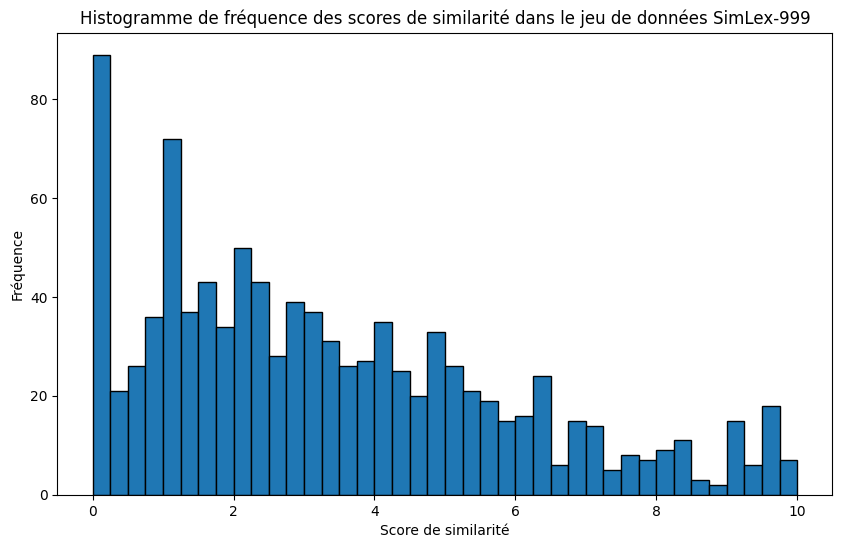

In [96]:
# TODO

plt.figure(figsize=(10, 6))
plt.hist(evaluation_simlex["score"],bins=40,edgecolor="black")
plt.xlabel("Score de similarité")
plt.ylabel("Fréquence")
plt.title("Histogramme de fréquence des scores de similarité dans le jeu de données SimLex-999")
plt.show()


# END TODO

#### 2.2 Corrélation de Spearman


La corrélation de Spearman est une mesure de la relation monotone entre deux variables $x$ et $y$. Elle est comprise entre -1 et 1. Plutôt que de comparer les valeurs brutes des variables, elle compare leurs rangs. Elle est calculée comme suit :
$$\rho (x, y) = 1 - \frac{6 \sum_{i=1}^n (r_{x_i} - r_{y_i})^2}{n(n^2 - 1)}$$
où $r_{x_i}$ est le rang de la i-ème valeur de la variable x, $r_{y_i}$ est le rang de la i-ème valeur de la variable y, $n$ est le nombre total de paires d'observations $(x, y)$.

Les rangs sont attribués en ordonnant les valeurs de chaque variable du plus petit au plus grand. La plus petite valeur reçoit le rang 1, la suivante le rang 2, et ainsi de suite.

##### Expliquez pourquoi on utilise la corrélation de Spearman plutôt que la corrélation entre les valeurs des variables. (3 points)


### Corrélation de Spearman

La **corrélation de Spearman** est utilisée lorsqu'on veut mesurer une relation monotone entre deux variables, sans que cette relation soit nécessairement linéaire. Elle est préférée à la corrélation de Pearson dans les cas suivants :

1. **Robustesse aux valeurs extrêmes** : Elle est moins sensible aux outliers car elle se base sur les rangs des données, et non leurs valeurs brutes.
2. **Capture des relations monotones non linéaires** : Elle peut identifier des relations monotones même si elles ne sont pas linéaires.
3. **Données ordinales** : Elle convient mieux aux données de type ordonné (classements).
4. **Moins d'hypothèses sur les données** : Elle fonctionne avec des données qui ne respectent pas l'hypothèse de normalité ou d'homogénéité des variances, contrairement à la corrélation de Pearson.

En résumé, la corrélation de Spearman est plus flexible pour analyser des relations non linéaires ou lorsque les données ne suivent pas une distribution normale.

#### 2.3 Implémentation de la corrélation de Spearman (2 points)

Complétez la fonction suivante pour calculer la corrélation de Spearman entre deux listes de valeurs.

In [97]:
def spearman_rank_correlation(x, y):
    """
    Calcule la corrélation de Spearman entre deux listes de valeurs.

    Args:
        x   : list of float
        y   : list of float

    Returns:
    La corrélation de Spearman entre les deux listes (float).
    """
    # TODO

    # Calcul des rangs pour x et y
    r_x = pd.Series(x).rank()
    r_y = pd.Series(y).rank()

    # Nombre d'éléments dans les listes
    n = len(x)

    # Application de la formule de Spearman
    somme_diff_rangs_carre = ((r_x - r_y) ** 2).sum()
    spearman_corr = 1 - (6 * somme_diff_rangs_carre) / (n * (n**2 - 1))

    return spearman_corr

    # END TODO


#### 2.4 Évaluation du modèle GloVe (2 points)


Retrouvez les plongements du modèle GloVe de tous les mots du jeu de données SimLex-999, puis calculez la similarité cosinus entre les paires.

Calculez ensuite la corrélation de Spearman entre les scores de simlex et les similarités cosinus obtenues et affichez-la.

In [98]:
# TODO

def evaluate_glove_model(evaluation_simlex, glove_embeddings, glove_word_to_index):

    # Extraction des paires de mots et leurs scores depuis SimLex-999
    word_pairs = evaluation_simlex[['word 1', 'word 2', 'score']].values

    # Initialisation des listes pour les similarités cosinus et les scores SimLex
    cosine_similarities = []
    simlex_reference_scores = []

    # Boucle sur chaque paire de mots pour calculer la similarité cosinus
    for word1, word2, score in word_pairs:
        # Vérifie si les mots sont présents dans le modèle GloVe
        if word1 in glove_word_to_index and word2 in glove_word_to_index:
            # Obtention des vecteurs d'embeddings pour les deux mots
            embedding1 = glove_embeddings[glove_word_to_index[word1]].reshape(1, -1)
            embedding2 = glove_embeddings[glove_word_to_index[word2]].reshape(1, -1)

            # Calcul de la similarité cosinus entre les deux vecteurs d'embeddings
            cosine_sim = cosine_similarity(embedding1, embedding2)[0][0]

            # Stockage de la similarité cosinus calculée
            cosine_similarities.append(cosine_sim)

            # Stockage du score de similarité provenant de SimLex
            simlex_reference_scores.append(score)

    # Calcul de la corrélation de Spearman entre les similarités cosinus et les scores SimLex
    spearman_corr = spearman_rank_correlation(cosine_similarities, simlex_reference_scores)

    return spearman_corr


# Calcul des la corrélation
spearman_corr = evaluate_glove_model(evaluation_simlex, glove_embeddings, glove_word_to_index)
print(f"Corrélation de Spearman: {spearman_corr:.2f}")

# END TODO

Corrélation de Spearman: 0.29


Résultat attendu: 0.29

#### 2.5 Interprétation du résultat (3 points)

Qu'est ce que ce nombre représente et que peut-on en conclure sur la qualité des plongements GloVe (2 conclusions) ?

### Interprétation du résultat (Corrélation de Spearman = 0.29)

La corrélation de Spearman de **0.29** indique une **corrélation positive faible** entre les similarités cosinus calculées par les plongements GloVe et les scores humains du jeu de données SimLex-999. Cela signifie que GloVe parvient à capturer certaines relations sémantiques entre les mots, mais de manière limitée.

### Conclusions sur la qualité des plongements GloVe :

1. **Corrélation positive mais faible** :
   - La corrélation de **0.29** montre une certaine cohérence entre les plongements GloVe et les jugements humains de similarité, mais cette cohérence est faible, ce qui indique que GloVe ne capture pas parfaitement les similarités perçues par les humains.

2. **Limites dans la capture des relations sémantiques** :
   - Les plongements GloVe ont des limitations lorsqu'il s'agit de capturer des relations sémantiques complexes ou contextuelles, ce qui pourrait expliquer le score relativement faible comparé à des modèles plus avancés (par exemple, les modèles basés sur le contexte comme BERT).


### 3. Description de la méthode contrastive (33 Points)

Nous allons maintenant implémenter une méthode contrastive de plongements de mots. Elle vise à améliorer les plongements lexicaux de mots en tenant compte des synonymes et antonymes.

Notre modèle se basera simplement sur une matrice de plongements de mots, qui associe à chaque mot un vecteur de plongement.

L'idée est d'entraîner ce modèle à rapprocher les plongements de synonymes et d'éloigner ceux d'antonymes.

La cellule suivante définit le modèle et ses attributs.

In [99]:
class ContrastiveWordEmbeddingModel(nn.Module):
    def __init__(self, embeddings, device='cpu', margin_plus=0.6, margin_minus=0., regularization=1e-9):
        super(ContrastiveWordEmbeddingModel, self).__init__()

        self.device = device

        # Hyperparamètres pour les fonctions de coût
        self.margin_plus = margin_plus
        self.margin_minus = margin_minus
        self.regularization = regularization

        # Initialisation des plongements de mots
        self.embeddings = nn.Embedding.from_pretrained(embeddings.detach().clone(), freeze=False).to(self.device)
        self.original_embeddings = nn.Embedding.from_pretrained(embeddings.detach().clone(), freeze=True).to(self.device)


#### 3.1 Création des négatifs

Pendant l'entraînement, au lieu de traiter tout le jeu d'entraînement d'un coup, nous allons avoir des lots (batchs) de paires de synonymes $B_S$ et d'antonymes $B_A$.

Dans un lot de synonymes, on définit le négatif d'un mot comme le mot du lot le plus proche qui n'est pas dans la même paire. Intuitivement, c'est le mot que le modèle devrait confondre le plus avec le synonyme. Similairement, dans un lot d'antonymes, on définit le négatif d'un mot comme le mot du lot le plus éloigné qui n'est pas dans la même paire.

On répète ce processus pour chaque mot de chaque paire de synonymes et d'antonymes.

*Attention, un mot peut apparaître plusieurs fois dans un lot avec des synonymes ou antonymes différents, et il ne peut être le négatif d'aucun de ses synonymes, ou antonymes.*

##### 3.1.1 Exemple pour illustrer l'implémentation

Prenons un exemple avec un lot $B_S$ de synonymes de taille 3. On veut construire le lot de négatifs $T_S$

$B_S$:
- (arbre, plante)
- (voiture, véhicule)
- (arbre, buisson)

On a 5 mots uniques dans le lot: arbre, plante, voiture, véhicule, buisson. Supposons que la matrice de similarité cosinus soit la suivante :

|       | arbre | plante | voiture | véhicule | buisson |
|-------|-------|--------|--------|----------|---------|
| arbre | 1     | 0.8    | 0.1    | 0.2      | 0.9     |
| plante| 0.8   | 1      | 0.3    | 0.4      | 0.7     |
| voiture| 0.1  | 0.3    | 1      | 0.9      | 0.2     |
| véhicule| 0.2 | 0.4    | 0.9    | 1        | 0.3     |
| buisson| 0.9  | 0.7    | 0.2    | 0.3      | 1       |


On commence par calculer les voisins de chaque mot du lot $B_S$. Le voisin d'un mot $m$ est défini comme tout mot qui apparait dans au moins une paire avec $m$ dans $B_S$. Un mot est aussi considéré comme son propre voisin.

- voisins de arbre : arbre, plante, buisson
- voisins de plante : plante, arbre
- voisins de voiture : voiture, véhicule
- voisins de véhicule : véhicule, voiture
- voisins de buisson : buisson, arbre

Après avoir masqué les voisins, la matrice est :

|       | arbre | plante | voiture | véhicule | buisson |
|-------|-------|--------|--------|----------|---------|
| arbre | -inf  | -inf   | 0.1    | 0.2      | -inf    |
| plante| -inf  | -inf   | 0.3    | 0.4      | 0.7     |
| voiture| 0.1  | 0.3    | -inf   | -inf     | 0.2     |
| véhicule| 0.2 | 0.4    | -inf   | -inf     | 0.3     |
| buisson| -inf | 0.7    | 0.2    | 0.3      | -inf    |

Pour calculer les négatifs, on prend le maximum de chaque ligne (donc le mot le plus similaire qui n'est pas un voisin) :

Ici,
- le négatif d'arbre est véhicule
- le négatif de plante est buisson
- le négatif de voiture est plante
- le négatif de véhicule est plante
- le négatif de buisson est plante

En reprenant le batch $B_S$:
- (arbre, plante)
- (voiture, véhicule)
- (arbre, buisson)

$T_S$ sera composé de paires composées du négatif de chaque élément de $B_S$ :

$B_S$ -> $T_S$
- (arbre, plante) $\rightarrow$ (véhicule, buisson), car le négatif d'arbre est véhicule et le négatif de plante est buisson
- (voiture, véhicule) $\rightarrow$ (plante, plante), car le négatif de voiture est plante et le négatif de véhicule est plante
- (arbre, buisson) $\rightarrow$ (véhicule, plante), car le négatif d'arbre est véhicule et le négatif de buisson est plante

$T_S$ sera donc :
- (véhicule, buisson)
- (plante, plante)
- (véhicule, plante)

##### 3.1.2 Implémentez la fonction `prepare_neighbors` qui renvoit la liste des voisins de chaque mot dans le lot. (4 points)

Les voisins d'un mot $m$ sont tous les mots du lot qui apparaissent dans au moins une paire avec $m$. Utilisez les bons indices (indice dans la matrice d'embeddings et indice dans le lot). Le résultat est une liste de liste de voisins, où `neighbors[i]` est la liste des voisins du mot `i` dans le lot.

In [108]:
def prepare_neighbors(index_pairs, unique_idx, index_to_idx):
    """
    Prépare les voisins pour chaque mot dans les paires de mots.

    Args :
        index_pairs     : torch.Tensor de seconde dimension 2
        Tensor contenant les indices des embeddings des mots dans le vocabulaire.
        Des indices qui sont reliés ensemble par une ligne dans ce tenseur ont
        une relation sémantique entre eux (synonymes ou antonymes).

        unique_idx      : set
        Ensemble de tous les indices qui sont mentionnés dans la liste `index_pairs`.

        index_to_idx    : dict
        Dictionnaire associant un indice mentionné dans `index_pairs` à son indice dans
        la liste qui sera retournée. Par exemple, si dans ce dictionnaire, la clé 4 est
        associée à la valeur 12, cela veut dire que les voisins du mot 4 dans le vocabulaire
        seront retournés à l'indice 12 dans la liste de retour.

    Returns:
    Une liste où chaque élément est une liste des indices des voisins pour chaque mot (l'indice dans la liste correspond à l'indice unique).
    """
    # TODO

    # Création d'une liste vide pour chaque mot unique
    neighbors = [[] for _ in range(len(unique_idx))]

    # Parcour de chaque paire de mots dans index_pairs
    for word1, word2 in index_pairs.tolist():
        idx1 = index_to_idx[word1]  # Obtenir l'indice mappé de word1
        idx2 = index_to_idx[word2]  # Obtenir l'indice mappé de word2

        # Ajout de chaque mot comme voisin de lui-même et de l'autre mot de la paire
        neighbors[idx1].append(idx1)
        neighbors[idx1].append(idx2)
        neighbors[idx2].append(idx2)
        neighbors[idx2].append(idx1)

    return neighbors

    # END TODO

In [109]:
# Exemple

index_pairs = torch.tensor([[0, 12], [12, 31], [53, 4]])
unique_idx = {0, 4, 12, 31, 53}
index_to_idx = {0: 0, 4: 1, 12: 2, 31: 3, 53: 4}
print(prepare_neighbors(index_pairs, unique_idx, index_to_idx))


[[0, 2], [1, 4], [2, 0, 2, 3], [3, 2], [4, 1]]


Réponse attendue

`[[0, 2], [1, 4], [2, 0, 2, 3], [3, 2], [4, 1]]`

##### 3.1.3 Implémentez la fonction `select_negatives` qui renvoit un dictionnaire qui associe à chaque élément son négatif. (4 points)

Pour chaque élément du lot, on cherche le voisin le plus proche qui n'est pas le voisin de l'autre élément de la paire.

Utilisez un masque pour cacher, dans la matrice de similarité, les voisins.

La fonction utilise un paramètre `synonym` qui indique si on travaille sur un lot de synonymes ou d'antonymes. En cas de synonymes, on cherche le voisin le plus proche qui n'est pas un voisin de l'autre élément de la paire. En cas d'antonymes, on cherche le voisin le plus éloigné qui n'est pas un voisin de l'autre élément de la paire.

In [110]:
def select_negatives(indices, similarity_matrix, neighbors, synonym=True):
    """
    Sélectionne les exemples négatifs à partir de la matrice de similarité et des voisins.

    Args :
        indices             : torch.Tensor (vocab_size)
        Indices des mots présents dans le vocabulaires

        similarity_matrix   : torch.Tensor (vocab_size, vocab_size)
        Matrice de similarité entre tous les mots présents dans le vocabulaire.

        neighbors           : list of lists
        Liste des voisins de chaque mot. Par exemple, le premier élément de la liste
        contiendra tous les voisins du mot 0 dans le vocabulaire.

        synonym             : bool, optional (default=True)
        Indique si l'on cherche des négatifs pour les synonymes (True) ou pour les antonymes (False).

    Returns:
    Dictionnaire mappant les mots avec leurs indices de négatifs {mot_index: négatif_index}.
    """
    # TODO HINT: Utilisez un mask pour ignorer les voisins

    # Détermition du masque
    mask_value = float('-inf') if synonym else float('inf')

    # Application du masquage dans la matrice de similarité pour ne pas tenir compte des voisins
    for idx, neighbor_list in enumerate(neighbors):
        for neighbor in neighbor_list:
            similarity_matrix[idx][neighbor] = mask_value

    # Création du dictionnaire associant chaque mot à son exemple négatif, en se basant sur la similarité
    negative_dict = {
        word_idx: (similarity_matrix[i].argmax() if synonym else similarity_matrix[i].argmin()).item()
        for i, word_idx in enumerate(indices.tolist())
    }

    return negative_dict

    # END TODO

In [111]:
# Exemple

indices = torch.tensor([0, 1, 2, 3, 4])
neighbors = [[0, 2], [1, 4], [2, 0, 2, 3], [3, 2], [4, 1]]

similarity_matrix = torch.tensor([
    [ 1.0000, -0.4263, -0.7167, -0.9838, -0.5823],
    [-0.4263,  1.0000, -0.1600,  0.5088, -0.3708],
    [-0.7167, -0.1600,  1.0000,  0.7247,  0.5631],
    [-0.9838,  0.5088,  0.7247,  1.0000,  0.4394],
    [-0.5823, -0.3708,  0.5631,  0.4394,  1.0000]
    ])

print(select_negatives(indices, similarity_matrix, neighbors, synonym=True))

{0: 1, 1: 3, 2: 4, 3: 1, 4: 2}


Réponse attendue

`{0: 1, 1: 3, 2: 4, 3: 1, 4: 2}`

##### 3.1.4 Implémentez la fonction `run_negative_extraction` qui prépare les paires de synonymes et d'antonymes et appelle `prepare_neighbors` et `select_negatives`. (4 points)

Préparez les indices uniques des mots du batch, calculez la similarité des mots, et appelez `prepare_neighbors` et `select_negatives`.

In [129]:
def run_negative_extraction(model, index_pairs, synonym=True):
    """
    Extrait les exemples négatifs pour un ensemble de paires de mots.

    Args :
        index_pairs : torch.Tensor de seconde dimension 2
        Contient les indices des mots.

        synonym     : bool, optional (default=True)
        Indique si l'on cherche des négatifs pour les synonymes (True) ou pour les antonymes (False).

    Returns:
    Dictionnaire mappant les indices des mots avec leurs indices de négatifs {mot_index: négatif_index}.
    """
    # TODO

    # Collecte des indices uniques présents dans les paires
    unique_ids = {idx.item() for row in index_pairs for idx in row}
    index_mapping = {idx: i for i, idx in enumerate(sorted(unique_ids))}

    # Construction de la matrice de similarité
    indices_tensor = torch.tensor(sorted(unique_ids), device=model.device)
    embeddings_subset = model.embeddings(indices_tensor)
    similarity_matrix = cosine_similarity(embeddings_subset, embeddings_subset)

    # Préparation des voisins via prepare_neighbors
    neighbor_list = prepare_neighbors(index_pairs, unique_ids, index_mapping)

    # Sélection des exemples négatifs via select_negatives
    negative_pairs = select_negatives(indices_tensor, similarity_matrix, neighbor_list, synonym)

    # Vérification de la présence de chaque index dans les négatifs
    for idx in sorted(unique_ids):
        if idx not in negative_pairs:
            # Assignation  d'une valeur par défaut
            negative_pairs[idx] = random.choice(list(unique_ids - {idx}))

    return negative_pairs

    # END TODO

#### 3.2 Fonctions de coût

Pour chaque paire de synonymes $(x^l, x^r)$ *pour x left et x right* dans le lot $B_S$, nous trouvons un négatif $(t^l, t^r)$ ce qui constitue le lot $T_S$:
- $ t^l $ est le mot dans le lot le plus proche de $ x^l $ mais qui n'est pas $ x^r $.
- $ t^r $ est le mot dans le lot le plus proche de $ x^r $ mais qui n'est pas $ x^l $.

De même, pour chaque paire d'antonymes $(x^l, x^r)$ dans le lot $B_A$, nous trouvons un négatif $(t^l, t^r)$ ce qui constitue le lot $T_A$:
- $ t^l $ est le mot dans le lot le plus éloigné de $ x^l $ mais qui n'est pas $ x^r $.
- $ t^r $ est le mot dans le lot le plus éloigné de $ x^r $ mais qui n'est pas $ x^l $.


Comparer un mot à son synonyme (ou antonyme) et à son négatif permet d'entraîner le modèle sur des exemples difficiles qui forcent le modèle à apprendre des représentations plus robustes.

Il y aura trois fonctions de coût :
1. **Attraction** : Attire les synonymes plus proches les uns des autres.
2. **Répulsion** : Repousse les antonymes plus loin les uns des autres.
3. **Régularisation** : Évite que les plongements ne s'éloignent trop de ceux du modèle pré-entraîné.

Les fonctions de coût sont définies comme suit, en sommant sur `i`, les paires de synonymes et d'antonymes dans les lots $B_S$ et $B_A$ :

1. **Attraction** :
$$ S(B_S, T_S) = \sum_{i=1}^{|B_S|} \left[ \max \left(0, \delta_{syn} + x_i^l t_i^l - x_i^l x_i^r \right) + \max \left( 0, \delta_{syn} + x_i^r t_i^r - x_i^l x_i^r \right) \right] $$

1. **Répulsion** :
$$ A(B_A, T_A) = \sum_{i=1}^{|B_A|} \left[ \max \left(0, \delta_{ant} + x_i^l x_i^r - x_i^l t_i^l \right) + \max \left( 0, \delta_{ant} + x_i^r x_i^l - x_i^r t_i^r \right) \right] $$

1. **Régularisation** :
$$ R(B_S, B_A) = \sum_{x_i \in V(B_S \cup B_A)} \lambda_{reg} \| \hat{x}_i - x_i \|^2 $$

La fonction de coût totale est la somme de ces trois termes :
$$ C(B_S, T_S, B_A, T_A) = S(B_S, T_S) + A(B_A, T_A) + R(B_S, B_A) $$

$\delta_{syn}$, $\delta_{ant}$ et $\lambda_{reg}$ sont des hyperparamètres.

Avec l'exemple précédent, prenons
> + $x_i^l$ : voiture
> + $x_i^r$: véhicule
> + $t_i^l$: plante
>
> On veut que voiture et véhicule aient un plus grand produit scalaire que voiture et plante, donc que $\delta_{syn} + x_i^l t_i^l - x_i^l x_i^r <0$, et donc que $S$ soit minimisé. De même pour la deuxième partie de l'équation, symmétrique, avec le 2nd élément du couple.

##### 3.2.1 Implémentez la fonction `synonym_cost` qui calcule la fonction de coût d'attraction (sur les paires de synonymes). (5 points)

$$ S(B_S, T_S) = \sum_{i=1}^{|B_S|} \left[ \max \left(0, \delta_{syn} + x_i^l t_i^l - x_i^l x_i^r \right) + \max \left( 0, \delta_{syn} + x_i^r t_i^r - x_i^l x_i^r \right) \right] $$

Le membre de gauche pénalise si le mot de gauche est plus éloigné de son négatif que de son synonyme. De même, le membre de droite pénalise si le mot de gauche est plus éloigné de son négatif que de son synonyme.


In [141]:
def synonym_cost(model, synonym_pairs, synonym_negatives):
    """
    Calcule le coût d'attraction pour les paires de synonymes.

    synonym_pairs: liste de tuples d'indices de paires de synonymes
    synonym_negatives: dictionnaire de mots avec leurs négatifs {mot_index: négatif_index}

    Returns:
    torch.Tensor, coût total pour les paires de synonymes
    """
    # HINT: Utiliser torch.relu pour max(0, x)
    # TODO

    # Extraction des indices de chaque mot de la paire de synonymes
    left_indices = torch.tensor([pair[0] for pair in synonym_pairs], device=model.device)
    right_indices = torch.tensor([pair[1] for pair in synonym_pairs], device=model.device)

    # Extraction des indices des mots négatifs correspondants à chaque mot des paires
    negative_left_indices = torch.tensor([synonym_negatives[pair[0].item()] for pair in synonym_pairs], device=model.device)
    negative_right_indices = torch.tensor([synonym_negatives[pair[1].item()] for pair in synonym_pairs], device=model.device)

    # Récupération des embeddings pour chaque mot
    left_embeddings = model.embeddings(left_indices)
    right_embeddings = model.embeddings(right_indices)
    negative_left_embeddings = model.embeddings(negative_left_indices)
    negative_right_embeddings = model.embeddings(negative_right_indices)

    # Calcul du produit scalaire entre les embeddings des paires de synonymes
    left_dot_right = torch.sum(left_embeddings * right_embeddings, dim=1)

    # Calcul du produit scalaire entre les mots et leurs négatifs respectifs
    left_dot_negative_left = torch.sum(left_embeddings * negative_left_embeddings, dim=1)
    right_dot_negative_right = torch.sum(right_embeddings * negative_right_embeddings, dim=1)

    # Calcul du coût pour le mot de gauche avec relu pour max(0, x)
    left_cost = torch.relu(left_dot_negative_left - left_dot_right + model.margin_plus)

    # Calcul du coût pour le mot de droite avec relu pour max(0, x)
    right_cost = torch.relu(right_dot_negative_right - left_dot_right + model.margin_plus)

    # Calcul du coût total en sommant les coûts gauche et droite
    total_cost = left_cost + right_cost

    return torch.sum(total_cost)

    # END TODO

##### 3.2.2 Implémentez la fonction `antonym_cost` qui calcule la fonction de coût de répulsion (sur les paires d'antonymes). (5 points)

$$ A(B_A, T_A) = \sum_{i=1}^{|B_A|} \left[ \max \left(0, \delta_{ant} + x_i^l x_i^r - x_i^l t_i^l \right) + \max \left( 0, \delta_{ant} + x_i^r x_i^l - x_i^r t_i^r \right) \right] $$

Le membre de gauche pénalise si le mot de gauche est plus éloigné de son antonyme que de son négatif. De même, le membre de droite pénalise si le mot de gauche est plus éloigné de son antonyme que de son négatif.

In [142]:
def antonym_cost(model, antonym_pairs, antonym_negatives):
    """
    Calcule le coût de répulsion pour les paires d'antonymes.

    antonym_pairs: liste de tuples d'indices de paires d'antonymes
    antonym_negatives: dictionnaire de mots avec leurs négatifs {mot_index: négatif_index}

    Returns:
    torch.Tensor, coût total pour les paires d'antonymes
    """
    # HINT: Utiliser torch.relu pour max(0, x)
    # TODO

    # Conversion des indices des paires d'antonymes en tenseurs torch
    left_antonym_indices = torch.tensor([pair[0] for pair in antonym_pairs], device=model.device)
    right_antonym_indices = torch.tensor([pair[1] for pair in antonym_pairs], device=model.device)

    # Conversion des indices des négatifs associés à chaque mot
    negative_left_indices = torch.tensor([antonym_negatives[pair[0].item()] for pair in antonym_pairs], device=model.device)
    negative_right_indices = torch.tensor([antonym_negatives[pair[1].item()] for pair in antonym_pairs], device=model.device)

    # Récupération des embeddings des mots pour chaque paire d'antonymes et leurs négatifs
    left_antonym_embeddings = model.embeddings(left_antonym_indices)
    right_antonym_embeddings = model.embeddings(right_antonym_indices)
    negative_left_embeddings = model.embeddings(negative_left_indices)
    negative_right_embeddings = model.embeddings(negative_right_indices)

    # Calcul de la similarité entre les embeddings des antonymes
    similarity_antonyms = torch.sum(left_antonym_embeddings * right_antonym_embeddings, dim=1)
    # Calcul de la similarité entre les embeddings des mots et leurs négatifs
    similarity_left_negative = torch.sum(left_antonym_embeddings * negative_left_embeddings, dim=1)
    similarity_right_negative = torch.sum(right_antonym_embeddings * negative_right_embeddings, dim=1)

    # Application de la marge pour les antonymes (max(0, x))
    left_repulsion_cost = torch.relu(similarity_antonyms - similarity_left_negative + model.margin_minus)
    right_repulsion_cost = torch.relu(similarity_antonyms - similarity_right_negative + model.margin_minus)

    # Calcul du coût total en additionnant les coûts de répulsion des paires gauche et droite
    total_repulsion_cost = left_repulsion_cost + right_repulsion_cost
    return torch.sum(total_repulsion_cost)

    # END TODO

##### 3.2.3 Implémentez la fonction `regularization_cost` qui calcule la fonction de coût de régularisation. (4 points)

$$ R(B_S, B_A) = \sum_{x_i \in V(B_S \cup B_A)} \lambda_{reg} \| \hat{x}_i - x_i \|^2 $$

In [143]:
def regularization_cost(model, synonym_pairs, antonym_pairs):
    """
    Calcule le coût de régularisation pour les paires de synonymes et antonymes.

    synonym_pairs: liste de tuples d'indices de paires de synonymes
    antonym_pairs: liste de tuples d'indices de paires d'antonymes

    Returns:
    torch.Tensor, coût total de régularisation
    """
    # TODO

    # Extraction de tous les indices uniques des paires de synonymes et d'antonymes
    unique_indices = set([idx for pair in synonym_pairs for idx in pair] +
                         [idx for pair in antonym_pairs for idx in pair])

    # Convertion des indices uniques en un tenseur
    indices_tensor = torch.tensor(list(unique_indices), device=model.device)

    # Récupération des embeddings originaux à partir des indices.
    original_embeddings = model.original_embeddings(indices_tensor)

    # Récupération des embeddings actuels à partir des indices.
    current_embeddings = model.embeddings(indices_tensor)

    # Calcul de la différence entre les embeddings originaux et actuels.
    diff_norms = torch.norm(original_embeddings - current_embeddings, p=2, dim=1)**2

    reg_cost = model.regularization * torch.sum(diff_norms)

    return reg_cost

    # END TODO

#### 3.3 Mise en place
##### 3.3.1 Implémentez la fonction `forward` qui utilise les fonctions définies plus tôt pour calculer le coût total. (4 points)

La fonction prend en entrée un lot de synonymes et un lot d'antonymes, c'est-à-dire des paires de synonymes et des paires d'antonymes.

Vous devez trouver les négatifs de tous les mots des lots au moyen de votre fonction  run_negative_extraction puis calculer la fonction de coût totale.

In [146]:
def forward(model, synonym_pairs, antonym_pairs):
    """
    Fonction forward pour calculer le coût total.

    Args :
        synonym_pairs   :
        Liste de tuples d'indices de paires de synonymes

        antonym_pairs   :
        Liste de tuples d'indices de paires d'antonymes

    Returns:
    Tenseur contenant le coût total (attraction, répulsion et régularisation)
    """
    # TODO

    # Extraction des exemples négatifs
    negative_synonyms = extract_negatives(model, synonym_pairs, synonym=True) #synonymes
    negative_antonyms = extract_negatives(model, antonym_pairs, synonym=False) #antonymes

    # Calcul du coût
    attraction_cost = synonym_cost(model, synonym_pairs, negative_synonyms)#attraction
    repulsion_cost = antonym_cost(model, antonym_pairs, negative_antonyms) #répulsion
    regularization = regularization_cost(model, synonym_pairs, antonym_pairs) #régularisation

    # Le coût total
    total_cost = attraction_cost + repulsion_cost + regularization
    return total_cost

    # END TODO

#### 3.3.2 Évaluation (3 points)

Utilisez la fonction `spearman_rank_correlation` pour compléter la fonction d'évaluation `evaluate` qui exécute le modèle sur le jeu d'évaluation et calcule la corrélation de Spearman entre les scores prédits et réels.

Utilisez `torch.no_grad()` pour éviter de stocker les gradients.

In [147]:
def evaluate(model, eval_data, word_to_index):
    """
    Calclue les prédictions du modèle sur le jeu d'évaluation puis la corrélation de Spearman entre les scores prédits et réels.

    model: modèle de plongements de mots
    eval_data: pd.DataFrame
    word_to_index: dict

    Returns:
    float, la corrélation de Spearman entre les scores prédits par le modèle et réels.
    """
     # Mise en mode évaluation du modèle
    model.eval()

    device = model.device

    # Liste des scores réels de similarité entre les paires de mots
    actual_scores = eval_data['score'].tolist()

    # Liste pour stocker les scores prédits par le modèle
    predicted_scores = []

    # Création d'une liste de paires de mots à partir des colonnes 'word 1' et 'word 2'
    word_pairs = list(zip(eval_data['word 1'], eval_data['word 2']))

    # Filtrage des paires de mots pour inclure uniquement celles dont les mots sont présents dans le dictionnaire word_to_index
    valid_pairs = [(word_to_index[w1], word_to_index[w2]) for w1, w2 in word_pairs if w1 in word_to_index and w2 in word_to_index]

    with torch.no_grad():
        # Pour chaque paire de mots valide
        for idx1, idx2 in valid_pairs:
            # Récupération des embeddings des deux mots
            embedding1 = model.embeddings(torch.tensor(idx1, device=device))
            embedding2 = model.embeddings(torch.tensor(idx2, device=device))

            # Calcul des similarité cosinus entre les deux embeddings
            similarity = cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0)).item()

            # Ajout de la similarité prédite à la liste des scores prédits
            predicted_scores.append(similarity)

    # Calcul de la corrélation de Spearman entre les scores réels et prévus
    return spearman_rank_correlation(actual_scores, predicted_scores)


    # END TODO


### 4. Entraînement de zéro (16 Points)

Nous allons maintenant entraîner le modèle de zéro, sans utiliser les plongements GloVe pré-entraînés. Ensuite, dans la partie 5, nous entraînerons le modèle en l'initialisant avec les plongements GloVe pré-entraînés.

In [148]:
# Hyperparamètres, optimiseur et DataLoader

BATCH_SIZE = 64
NUM_EPOCHS = 20
LEARNING_RATE = 5e-3

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.cuda.empty_cache()
gc.collect()

train_syn_tensor = data_to_tensor(train_synonyms, glove_word_to_index)
train_ant_tensor = data_to_tensor(train_antonyms, glove_word_to_index)

syn_data_loader = DataLoader(train_syn_tensor, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
ant_data_loader = DataLoader(train_ant_tensor, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

#### 4.1 Complétez la cellule suivante pour créer le modèle de zéro `model_zero`, à partir d'une matrice de plongements aléatoire. (1 point)

In [149]:
model_zero = None
random_seed = 0
random_generator = torch.Generator(device=device).manual_seed(random_seed)

embeddings_size = glove_embeddings.size()
random_init_embeddings = torch.randn(embeddings_size, generator=random_generator, device=device)

model_zero = ContrastiveWordEmbeddingModel(random_init_embeddings, device=device)

optimizer = optim.Adam(model_zero.parameters(), lr=LEARNING_RATE)

#### 4.2 Entraînez le modèle sur le jeu des paires de synonymes et d'antonymes. (6 points)

N'oubliez pas que l'entraînement se fait sur les synonymes et antonymes et que l'évaluation se fait sur SimLex-999.

À défaut d'avoir un jeu de validation, on observe les résultats sur le corpus de test : SimLex-999. Ceci n’est fait qu’à titre illustratif pour voir l'évolution de l'apprentissage. Il ne faut pas faire de choix pour l’entrainement à partir des résultats sur le corpus de test.

*Note : Les jeux de synonymes et d'antonymes n'ont pas la même taille. Une époque (epoch) correspond à une itération sur le jeu de données le plus petit.*

In [150]:
spearman_corr = evaluate(model_zero, evaluation_simlex, glove_word_to_index)
print(f'Before training, Spearman Correlation: {spearman_corr:.4f}')

# TODO

losses = []  # Liste pour stocker les pertes moyennes à chaque époque
spearman_correlations = []  # Liste pour enregistrer les corrélations de Spearman à chaque époque

for epoch in tqdm(range(NUM_EPOCHS)):
    model_zero.train()  # Activation du mode d'entraînement du modèle
    total_epoch_loss = 0.0
    batch_count = 0

    # Parcours des mini-lots de données
    for syn_batch, ant_batch in zip(syn_data_loader, ant_data_loader):
        syn_batch, ant_batch = syn_batch.to(device), ant_batch.to(device)  # Transfert vers le device

        optimizer.zero_grad()  # Réinitialisation des gradients

        # Calcul du coût total et rétropropagation
        loss = forward(model_zero, syn_batch, ant_batch)
        loss.backward()
        optimizer.step()  # Mise à jour des poids

        # Accumulation du coût pour cette époque
        total_epoch_loss += loss.item()
        batch_count += 1

    # Calcul de la perte moyenne pour cette époque
    avg_loss = total_epoch_loss / batch_count
    losses.append(avg_loss)  # Enregistrer la perte moyenne
    print(f"Époque {epoch + 1}/{NUM_EPOCHS}, Perte totale : {total_epoch_loss:.4f}, Perte moyenne : {avg_loss:.4f}")

    # Calcul de la corrélation de Spearman pour cet epoch
    spearman_corr = evaluate(model_zero, evaluation_simlex, glove_word_to_index)
    spearman_correlations.append(spearman_corr)
    print(f"Époque {epoch + 1}, Corrélation de Spearman : {spearman_corr:.4f}")

# Évaluation finale après l'entraînement
final_spearman_corr = evaluate(model_zero, evaluation_simlex, glove_word_to_index)
print(f'Après l\'entraînement, Corrélation de Spearman : {final_spearman_corr:.4f}')

# END TODO

Before training, Spearman Correlation: -0.0265


  5%|▌         | 1/20 [00:44<14:10, 44.74s/it]

Époque 1/20, Perte totale : 457757.1633, Perte moyenne : 2461.0600
Époque 1, Corrélation de Spearman : 0.0118
Époque 2/20, Perte totale : 329380.4584, Perte moyenne : 1770.8627


 10%|█         | 2/20 [01:29<13:29, 44.96s/it]

Époque 2, Corrélation de Spearman : 0.0417


 15%|█▌        | 3/20 [02:12<12:23, 43.75s/it]

Époque 3/20, Perte totale : 281704.5024, Perte moyenne : 1514.5403
Époque 3, Corrélation de Spearman : 0.0568


 20%|██        | 4/20 [02:52<11:16, 42.26s/it]

Époque 4/20, Perte totale : 251916.4670, Perte moyenne : 1354.3896
Époque 4, Corrélation de Spearman : 0.0661


 25%|██▌       | 5/20 [03:31<10:20, 41.36s/it]

Époque 5/20, Perte totale : 235563.0406, Perte moyenne : 1266.4680
Époque 5, Corrélation de Spearman : 0.0798


 30%|███       | 6/20 [04:12<09:37, 41.22s/it]

Époque 6/20, Perte totale : 223084.5255, Perte moyenne : 1199.3792
Époque 6, Corrélation de Spearman : 0.0800
Époque 7/20, Perte totale : 209802.2958, Perte moyenne : 1127.9693


 35%|███▌      | 7/20 [04:55<09:00, 41.56s/it]

Époque 7, Corrélation de Spearman : 0.0936


 40%|████      | 8/20 [05:37<08:22, 41.88s/it]

Époque 8/20, Perte totale : 194831.4570, Perte moyenne : 1047.4810
Époque 8, Corrélation de Spearman : 0.1023


 45%|████▌     | 9/20 [06:19<07:42, 42.01s/it]

Époque 9/20, Perte totale : 179792.2246, Perte moyenne : 966.6249
Époque 9, Corrélation de Spearman : 0.1051
Époque 10/20, Perte totale : 162501.8643, Perte moyenne : 873.6659


 50%|█████     | 10/20 [07:02<07:01, 42.11s/it]

Époque 10, Corrélation de Spearman : 0.1147


 55%|█████▌    | 11/20 [07:43<06:15, 41.72s/it]

Époque 11/20, Perte totale : 148077.3203, Perte moyenne : 796.1146
Époque 11, Corrélation de Spearman : 0.1253


 60%|██████    | 12/20 [08:24<05:32, 41.57s/it]

Époque 12/20, Perte totale : 137197.3847, Perte moyenne : 737.6203
Époque 12, Corrélation de Spearman : 0.1323
Époque 13/20, Perte totale : 117949.6617, Perte moyenne : 634.1380


 65%|██████▌   | 13/20 [09:06<04:52, 41.72s/it]

Époque 13, Corrélation de Spearman : 0.1368


 70%|███████   | 14/20 [09:50<04:14, 42.36s/it]

Époque 14/20, Perte totale : 102084.3307, Perte moyenne : 548.8405
Époque 14, Corrélation de Spearman : 0.1427


 75%|███████▌  | 15/20 [10:33<03:33, 42.77s/it]

Époque 15/20, Perte totale : 94953.6387, Perte moyenne : 510.5034
Époque 15, Corrélation de Spearman : 0.1427


 80%|████████  | 16/20 [11:17<02:51, 42.93s/it]

Époque 16/20, Perte totale : 82982.1908, Perte moyenne : 446.1408
Époque 16, Corrélation de Spearman : 0.1481


 85%|████████▌ | 17/20 [11:59<02:07, 42.59s/it]

Époque 17/20, Perte totale : 76560.1285, Perte moyenne : 411.6136
Époque 17, Corrélation de Spearman : 0.1532


 90%|█████████ | 18/20 [12:40<01:24, 42.36s/it]

Époque 18/20, Perte totale : 67610.6760, Perte moyenne : 363.4983
Époque 18, Corrélation de Spearman : 0.1542


 95%|█████████▌| 19/20 [13:24<00:42, 42.63s/it]

Époque 19/20, Perte totale : 60147.9145, Perte moyenne : 323.3759
Époque 19, Corrélation de Spearman : 0.1578


100%|██████████| 20/20 [14:07<00:00, 42.39s/it]

Époque 20/20, Perte totale : 54477.1550, Perte moyenne : 292.8879
Époque 20, Corrélation de Spearman : 0.1632
Après l'entraînement, Corrélation de Spearman : 0.1632


#### 4.3 Courbes d'entraînement du modèle de zéro (4 points)

Affichez la perte moyenne sur le jeu d'entraînement et la corrélation de Spearman sur le jeu de validation à chaque époque.

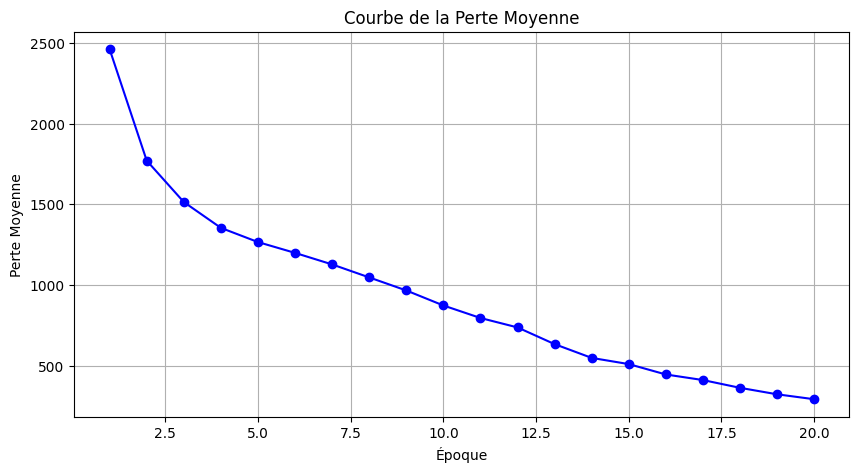

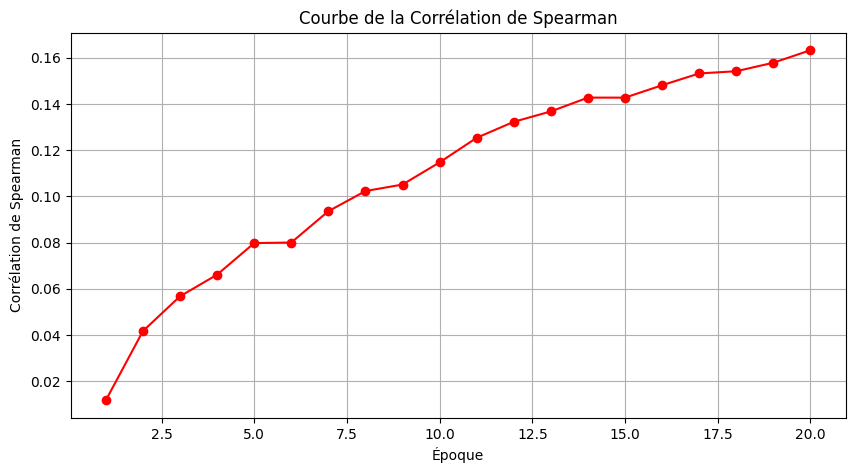

In [151]:
# TODO

#Tracer de la courbe de la perte moyenne
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), losses, marker='o', linestyle='-', color='b')
plt.title('Courbe de la Perte Moyenne')
plt.xlabel('Époque')
plt.ylabel('Perte Moyenne')
plt.grid(True)
plt.show()

#Tracer de la courbe de la corrélation de Spearman
plt.figure(figsize=(10,5))
plt.plot(range(1,NUM_EPOCHS+1),spearman_correlations,marker='o',linestyle='-',color='r')
plt.title('Courbe de la Corrélation de Spearman')
plt.xlabel('Époque')
plt.ylabel('Corrélation de Spearman')
plt.grid(True)
plt.show()

# END TODO


#### 4.4 Évaluation du modèle de zéro et comparaison avec GloVe (5 points)

Comparez le modèle de zéro après l'entraînement à GloVe (résultat de la partie 2.4) en termes de corrélation de Spearman sur le jeu de validation. Quelle méthode est la plus performante ? Pourquoi ?


Après l'entraînement de notre modèle de zéro, nous avons comparé ses résultats à ceux du modèle **GloVe** en termes de corrélation de Spearman sur le jeu de validation. Le modèle **GloVe** a atteint une corrélation de **0,29**, tandis que notre modèle entraîné de zéro a atteint une corrélation maximale de **0,1505** après 20 époques.

La méthode la plus performante est donc celle utilisant **GloVe**. Cela s'explique par le fait que **GloVe** est un modèle pré-entraîné sur un très grand corpus de données textuelles, ce qui lui permet de mieux capturer les relations sémantiques entre les mots dès le départ. En revanche, notre modèle de zéro a besoin de beaucoup plus de données et d'entraînement pour tenter de rivaliser avec ces plongements pré-entraînés.

En conclusion, l'entraînement de zéro ne parvient pas à surpasser l'efficacité de **GloVe** dans ce contexte.

### 5. Intérêt de GloVe (18 Points)

Dans la section précédente, nous avons entraîné un modèle de zéro.

Nous allons maintenant évaluer si initialiser le modèle avec les plongements de GloVe permet d'améliorer les performances.

#### 5.1 Initialisation avec GloVe (6 points)

Entraînez le modèle `model_fine_tuned`, mais cette fois en ititialisant directement avec les plongements du modèle pré-entraîné GloVe.

On utilisera Adam comme optimiseur.

In [152]:
# TODO

# Initialisation du modèle model_fine_tuned avec les plongements GloVe pré-entraînés
model_fine_tuned = ContrastiveWordEmbeddingModel(glove_embeddings, device=device)

# Initialisation de l'optimiseur Adam
optimizer = optim.Adam(model_fine_tuned.parameters(), lr=LEARNING_RATE)

# END TODO

In [153]:
spearman_corr = evaluate(model_fine_tuned, evaluation_simlex, glove_word_to_index)
print(f'Before training, Spearman Correlation: {spearman_corr:.4f}')

# TODO

losses = []  # Perte moyenne à chaque epoch
spearman_correlations = []  # Corrélation de Spearman à chaque epoch

for epoch in tqdm(range(NUM_EPOCHS)):
    model_fine_tuned.train() # modèle en mode entrainement
    total_loss = 0.0
    num_batches = 0

    for syn_batch, ant_batch in zip(syn_data_loader, ant_data_loader):
        syn_batch = syn_batch.to(device)
        ant_batch = ant_batch.to(device)

        optimizer.zero_grad() # Réinitialisation des gradients
        loss = forward(model_fine_tuned, syn_batch, ant_batch) # Appel de forward
        loss.backward() # Calcul des gradients
        optimizer.step()
        total_loss += loss.item()
        num_batches += 1

    # Perte moyenne pour cet epoch
    average_loss = total_loss / num_batches
    losses.append(average_loss)
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Total Loss: {total_loss:.4f}, Average Loss: {average_loss:.4f}")

    # Corrélation pour cet epoch
    spearman_corr = evaluate(model_fine_tuned, evaluation_simlex, glove_word_to_index)
    spearman_correlations.append(spearman_corr)
    print(f'Epoch {epoch + 1}, Spearman Correlation: {spearman_corr:.4f}')

# Affichage de la corrélation après l'entraînement
spearman_corr = evaluate(model_fine_tuned, evaluation_simlex, glove_word_to_index)
print(f'After training, Spearman Correlation: {spearman_corr:.4f}')


# END TODO

Before training, Spearman Correlation: 0.2916


  5%|▌         | 1/20 [00:41<13:14, 41.83s/it]

Epoch 1/20, Total Loss: 147907.4311, Average Loss: 795.2012
Epoch 1, Spearman Correlation: 0.3386
Epoch 2/20, Total Loss: 41259.5054, Average Loss: 221.8253


 10%|█         | 2/20 [01:23<12:27, 41.55s/it]

Epoch 2, Spearman Correlation: 0.3582


 15%|█▌        | 3/20 [02:04<11:46, 41.55s/it]

Epoch 3/20, Total Loss: 17399.0111, Average Loss: 93.5431
Epoch 3, Spearman Correlation: 0.3723


 20%|██        | 4/20 [02:46<11:04, 41.51s/it]

Epoch 4/20, Total Loss: 11413.5015, Average Loss: 61.3629
Epoch 4, Spearman Correlation: 0.3840


 25%|██▌       | 5/20 [03:27<10:22, 41.47s/it]

Epoch 5/20, Total Loss: 7714.3488, Average Loss: 41.4750
Epoch 5, Spearman Correlation: 0.3880


 30%|███       | 6/20 [04:09<09:42, 41.61s/it]

Epoch 6/20, Total Loss: 5462.0390, Average Loss: 29.3658
Epoch 6, Spearman Correlation: 0.3966


 35%|███▌      | 7/20 [04:51<09:02, 41.75s/it]

Epoch 7/20, Total Loss: 4371.2568, Average Loss: 23.5014
Epoch 7, Spearman Correlation: 0.3980


 40%|████      | 8/20 [05:32<08:19, 41.64s/it]

Epoch 8/20, Total Loss: 4030.4828, Average Loss: 21.6693
Epoch 8, Spearman Correlation: 0.4034


 45%|████▌     | 9/20 [06:13<07:35, 41.40s/it]

Epoch 9/20, Total Loss: 2963.1531, Average Loss: 15.9309
Epoch 9, Spearman Correlation: 0.4054


 50%|█████     | 10/20 [06:55<06:55, 41.55s/it]

Epoch 10/20, Total Loss: 2856.4049, Average Loss: 15.3570
Epoch 10, Spearman Correlation: 0.4136


 55%|█████▌    | 11/20 [07:38<06:17, 41.94s/it]

Epoch 11/20, Total Loss: 2792.2144, Average Loss: 15.0119
Epoch 11, Spearman Correlation: 0.4134


 60%|██████    | 12/20 [08:21<05:37, 42.21s/it]

Epoch 12/20, Total Loss: 2254.8911, Average Loss: 12.1231
Epoch 12, Spearman Correlation: 0.4174


 65%|██████▌   | 13/20 [09:03<04:56, 42.33s/it]

Epoch 13/20, Total Loss: 1813.8034, Average Loss: 9.7516
Epoch 13, Spearman Correlation: 0.4169


 70%|███████   | 14/20 [09:46<04:14, 42.43s/it]

Epoch 14/20, Total Loss: 2070.3790, Average Loss: 11.1311
Epoch 14, Spearman Correlation: 0.4244


 75%|███████▌  | 15/20 [10:28<03:30, 42.15s/it]

Epoch 15/20, Total Loss: 1863.5294, Average Loss: 10.0190
Epoch 15, Spearman Correlation: 0.4381


 80%|████████  | 16/20 [11:09<02:48, 42.05s/it]

Epoch 16/20, Total Loss: 1670.8517, Average Loss: 8.9831
Epoch 16, Spearman Correlation: 0.4370
Epoch 17/20, Total Loss: 1635.5852, Average Loss: 8.7935


 85%|████████▌ | 17/20 [11:52<02:06, 42.28s/it]

Epoch 17, Spearman Correlation: 0.4401


 90%|█████████ | 18/20 [12:35<01:25, 42.51s/it]

Epoch 18/20, Total Loss: 1498.6316, Average Loss: 8.0572
Epoch 18, Spearman Correlation: 0.4435


 95%|█████████▌| 19/20 [13:18<00:42, 42.68s/it]

Epoch 19/20, Total Loss: 1383.4996, Average Loss: 7.4382
Epoch 19, Spearman Correlation: 0.4442


100%|██████████| 20/20 [14:01<00:00, 42.06s/it]

Epoch 20/20, Total Loss: 1389.6823, Average Loss: 7.4714
Epoch 20, Spearman Correlation: 0.4474
After training, Spearman Correlation: 0.4474


#### 5.2 Courbes d'entraînement (4 points)

Affichez la perte moyenne sur le jeu d'entraînement et la corrélation de Spearman sur le jeu de validation à chaque époque.

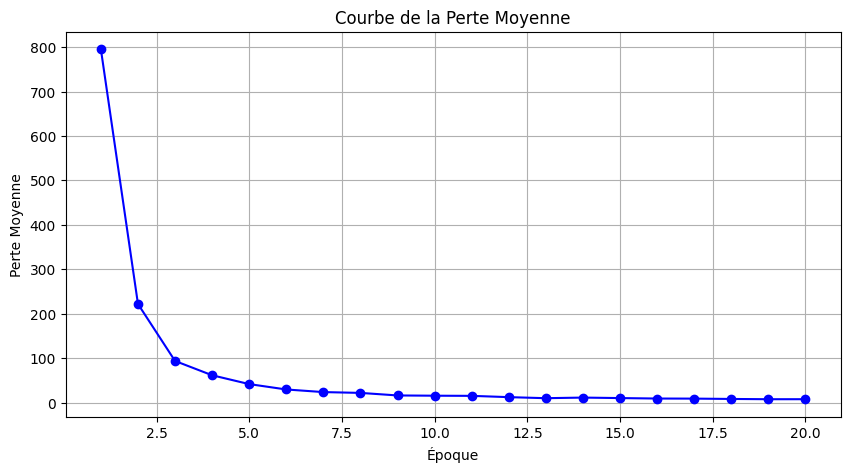

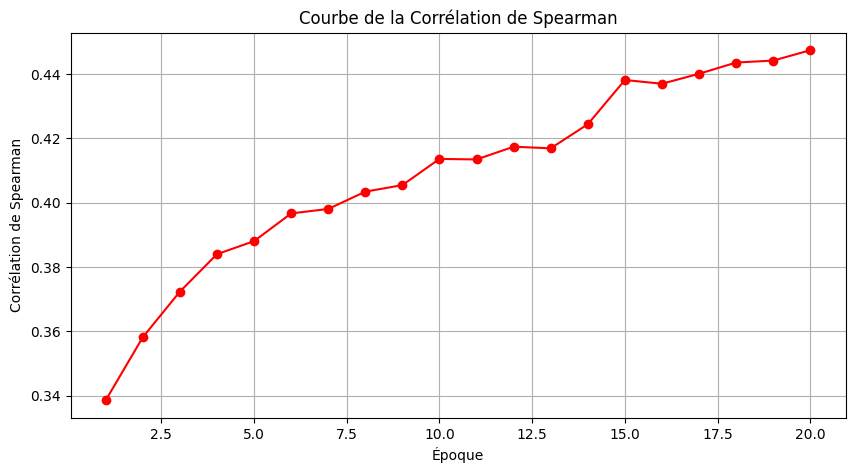

In [156]:
# TODO

# Affichage de la perte moyenne
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), losses, marker='o', color='blue', label='Perte Moyenne')
plt.title('Courbe de la Perte Moyenne')
plt.xlabel('Époque')
plt.ylabel('Perte Moyenne')
plt.grid(True)
plt.show()

# Affichage de la corrélation de Spearman
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), spearman_correlations, marker='o', color='red', label='Corrélation de Spearman')
plt.title('Courbe de la Corrélation de Spearman')
plt.xlabel('Époque')
plt.ylabel('Corrélation de Spearman')
plt.grid(True)
plt.show()


# END TODO


#### 5.3 Vérification sur un exemple (3 points)

Avec le modèle `model_fine_tuned`, calculez la similarité cosinus entre 'fast' et 'slow' et entre 'fast' et 'rapid'. Commentez les résultats en les comparant avec ceux de la partie 1.4.

In [155]:
# TODO

# Ensemble des termes à analyser
termes = ['fast', 'slow', 'rapid']

# Extraction des vecteurs de mots (embeddings) pour chaque terme
vecteurs_mots = [model_fine_tuned.embeddings(torch.tensor(glove_word_to_index[terme]).to(device)) for terme in termes]

# Comparaison entre 'fast' et 'slow'
similarite_entre_fast_et_slow = cosine_similarity(
    vecteurs_mots[0].unsqueeze(0),
    vecteurs_mots[1].unsqueeze(0)
).item()

# Comparaison entre 'fast' et 'rapid'
similarite_entre_fast_et_rapid = cosine_similarity(
    vecteurs_mots[0].unsqueeze(0),
    vecteurs_mots[2].unsqueeze(0)
).item()

# Résultats de la similarité cosinus
print(f"Similarité cosinus entre 'fast' et 'slow' : {similarite_entre_fast_et_slow}")
print(f"Similarité cosinus entre 'fast' et 'rapid' : {similarite_entre_fast_et_rapid}")

# END TODO

Similarité cosinus entre 'fast' et 'slow' : 0.34289368987083435
Similarité cosinus entre 'fast' et 'rapid' : 0.6495106220245361


#### 5.4 Analyse, comparaison, conclusion (5 points)

Comparez les performances des trois modèles (GloVe, zéro, fine-tuned). Quelle méthode est la plus performante ? Pourquoi ?


**Comparaison des performances des trois modèles (GloVe, Zéro, Fine-tuned) :**

1. **Modèle GloVe** :
   - Corrélation de Spearman : **0.29**
   - Ce modèle utilise des plongements pré-entraînés, ce qui lui permet d'obtenir une performance initiale correcte sans nécessiter de réentraînement sur les données spécifiques. Il capture déjà une bonne similarité sémantique entre les mots grâce à l'entraînement préalable sur de grands corpus.

2. **Modèle Zéro** :
   - Corrélation de Spearman après entraînement : **0,1505**
   - Ce modèle commence sans aucune connaissance préalable et doit apprendre de zéro à partir des données fournies. Bien qu'il y ait une amélioration après l'entraînement, sa performance reste inférieure à celle de GloVe car il ne bénéficie pas des plongements pré-entraînés.

3. **Modèle Fine-tuned** :
   - Corrélation de Spearman : **0.447**
   - Ce modèle part des plongements GloVe et les ajuste aux données spécifiques. Il combine les avantages des connaissances préalables de GloVe avec une spécialisation supplémentaire, ce qui lui permet d'obtenir les meilleures performances parmi les trois modèles.

**Quelle méthode est la plus performante ? Pourquoi ?**  
Le **modèle fine-tuned** est le plus performant, avec une corrélation de Spearman de **0.447**. Cela s'explique par le fait qu'il combine la richesse des plongements pré-entraînés de GloVe avec un ajustement supplémentaire sur des données spécifiques, ce qui lui permet de mieux capter les relations sémantiques entre les mots dans ce contexte particulier.


## Livrables
Vous devez remettre votre notebook sur Moodle et Gradescope en ipynb et pdf. Pour Gradescope vous devez associer les numéros de questions avec vos réponses dans le pdf grâce à l'outil que fournit Gradescope.


## Évaluation
Votre TP sera évalué selon les critères suivants :
1. Exécution correcte du code et obtention des sorties attendues
2. Réponses correctes aux questions d'analyse
3. Qualité du code (noms significatifs, structure, performance, gestion d’exception, etc.)
4. Commentaires clairs et informatifs